In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import datetime as dtt
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [83]:
# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(func.max(Measurement.date)).first()
print(max_date[0])
end_date = dtt.strptime(max_date[0],'%Y-%m-%d')
start_date = end_date - dt.timedelta(days=365)
print(start_date)

2017-08-23
2016-08-23 00:00:00


In [85]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the date and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(results, columns = ['Date', 'rainfall'])
precip_df.sort_values(by='Date')
precip_df.set_index('Date')
precip_df.head()

,Date,rainfall
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


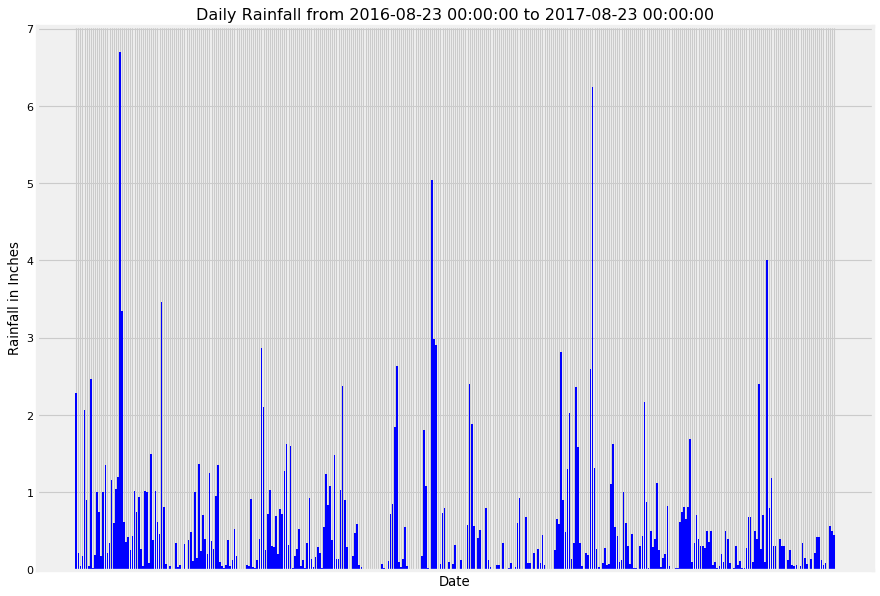

In [26]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(precip_df['Date'], precip_df['rainfall'], color='blue')
plt.xlabel("Date")
plt.ylabel("Rainfall in Inches")
plt.title(f"Daily Rainfall from {start_date} to {end_date}")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

![precipitation](Images/precipitation.png)

In [22]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df['rainfall'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: rainfall, dtype: float64

![describe](Images/describe.png)

In [25]:
# Design a query to show how many stations are available in this dataset?
num_of_stations = session.query(Station).count()
print(f"There are {num_of_stations} stations")


There are 9 stations


In [77]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
results = session.query(Measurement.station, Station.name).\
    filter(Measurement.station == Station.station)


stations_df = pd.DataFrame(results, columns = ['StationID', 'StationName'])
station_counts_df = stations_df['StationID'].value_counts().reset_index().rename(columns={'index': 'StationID', 1: 'count'})

busiest_station = station_counts_df.iloc[0,0]
print(f'The Station with the most observations is:  {busiest_station}')

The Station with the most observations is:  USC00519281


In [82]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
results = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == busiest_station)

temp_df = pd.DataFrame(results, columns = ['StationID', 'Temp'])
#temp_df['Temp'].describe()
avg_temp = round(temp_df['Temp'].describe()['mean'],2)
min_temp = round(temp_df['Temp'].describe()['min'], 2)
max_temp = round(temp_df['Temp'].describe()['max'], 2)
print(f'For Station {busiest_station} the average temp is {avg_temp}, the minimum is {min_temp} and the maximum is {max_temp}')

For Station USC00519281 the average temp is 71.66, the minimum is 54.0 and the maximum is 85.0


In [33]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# busiest_station, start_date
results = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == busiest_station).\
    filter(Measurement.date >= start_date)

temp_for_hist_df = pd.DataFrame(results, columns = ['StationID', 'Temp'])
temp_for_hist_df

,StationID,Temp
0,USC00519281,77.0
1,USC00519281,80.0
2,USC00519281,80.0
3,USC00519281,75.0
4,USC00519281,73.0
...,...,...
346,USC00519281,77.0
347,USC00519281,77.0
348,USC00519281,76.0
349,USC00519281,76.0


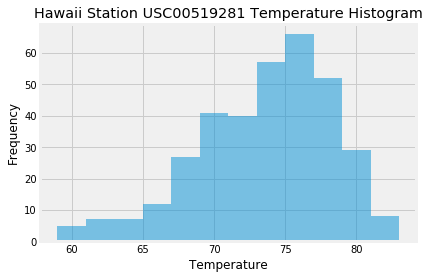

In [37]:
plt.hist(temp_for_hist_df['Temp'], bins = 12, alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f"Hawaii Station {busiest_station} Temperature Histogram")
plt.grid(True)

plt.show()

![precipitation](Images/station-histogram.png)

In [39]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps(start_date, end_date))

[(58.0, 74.57894736842105, 87.0)]


In [86]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2016-09-10'
end_date = '2016-09-17'
my_trip_temps = calc_temps(start_date, end_date)
trip_avg_temp = my_trip_temps[0][1]
trip_tmin_temp = my_trip_temps[0][0]
trip_tmax_temp = my_trip_temps[0][2]
print(trip_avg_temp, trip_tmin_temp, trip_tmax_temp)

77.3 71.0 83.0


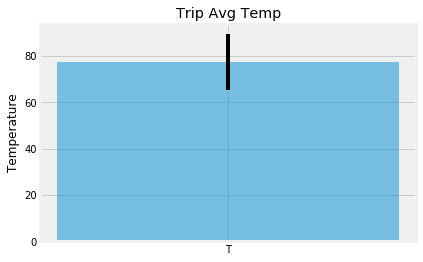

In [87]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

y_bar = trip_tmax_temp - trip_tmin_temp
objects = ('T')
y_pos = np.arange(len(objects))
performance = [trip_avg_temp]

plt.bar(y_pos, performance, align='center', alpha=0.5, yerr=y_bar)
plt.xticks(y_pos, objects)
plt.ylabel('Temperature')
plt.title('Trip Avg Temp')

plt.show()

In [ ]:
# Get column names of Station tables

In [122]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2010-01-01'
end_date = '2010-02-01'
results = session.query(func.sum(Measurement.prcp), Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

print(f'For the dates {start_date} to {end_date}, the total precipitation was: \n')
for result in results:
    print(result)
 

total_rainfall_df = pd.DataFrame(results, columns = ['Precipitation', 'Station ID', 'Station Name', 'Latitude', 'Longitude', 'Elevation'])

total_rainfall_df

For the dates 2010-01-01 to 2010-02-01, the total precipitation was: 

(5.9399999999999995, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(4.84, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(3.26, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(3.23, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
(0.91, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
(0.8400000000000001, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)
(0.3600000000000001, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)


,Precipitation,Station ID,Station Name,Latitude,Longitude,Elevation
0,5.94,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
1,4.84,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,3.26,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,3.23,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
4,0.91,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
5,0.84,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
6,0.36,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


## Optional Challenge Assignment

In [117]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start_date = '2016-01-01'
end_date = '2016-02-01'

# Use the start and end date to create a range of dates

# Strip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
